purpose: generate network colocalization values for Locomotor-Externalizing network and compare NPS scores

# set-up

In [1]:
import os
import pandas as pd
import ndex2
import networkx as nx
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
import sys
import random
#os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
#from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *
from plotting_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")
from matplotlib_venn import venn3


In [2]:
random_seed=random.seed(211)

In [3]:
save_fig=True

In [4]:
#whether to rerun the significance analysis for network colocalization
rerun_colocalization=False

In [5]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# functions

In [6]:
plt.rcParams.update({'font.size': 16})

# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [7]:
tissue_network=False
export_network=False

In [8]:
if tissue_network==False:
    interactome_name='PCNet2.0'
    if (interactome_name=='PCNet2.0')&(export_network==False):
        all_nodes=list(pd.read_csv('PCNET2.0_allNodes.tsv',header=None)[0])
    else:
        interactome=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)
        all_nodes=list(interactome.nodes())
else:
    netdir='tissue_networks/intermediate/'
    tissue='global'
    interactome_name=f'hb_tissue_{tissue}_top'
    #import node list
    with open(f'{netdir}node_list_{tissue}_top.txt', 'r') as file:
        lines = file.readlines()
    # Remove newline characters from each line
    all_nodes=[line.strip() for line in lines]

# import NPS scores and seed genes

In [16]:
cut_single=1.5
cut_comb=3

In [17]:
if not tissue_network:
    seed_dict=import_seed_dict(mag_dir,file_dict,ctrl_traits,ctrl_traits_rat,bonf_dict,gene_col_dict,all_nodes)
else:
    hgnc=pd.read_csv('hgnc_complete_set.txt',sep='\t',low_memory=False)
    hgnc=hgnc[['symbol','entrez_id']].dropna()
    hgnc['entrez_id']=hgnc['entrez_id'].astype(int).astype(str)
    seed_dict=import_seed_dict(mag_dir,file_dict,ctrl_traits,ctrl_traits_rat,bonf_dict,gene_col_dict,hgnc[hgnc.entrez_id.isin(all_nodes)]['symbol'])
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR', 'loco_final_cf_bonf', 'loco_final_cf_top500', 'loco_final_cf_FDR', 'loco_final_mega_bonf', 'loco_final_mega_top500', 'loco_final_mega_FDR', 'ext_rat_bonf', 'ext_rat_top500', 'ext_rat_FDR', 'loco_final_cf_rat_bonf', 'loco_final_cf_rat_top500', 'loco_final_cf_rat_FDR', 'ext_db_bonf', 'ext_db_top500', 'ext_db_FDR', 'ext_rtb_bonf', 'ext_rtb_top500', 'ext_rtb_FDR', 'loco_final_cf_25_bonf', 'loco_final_cf_25_top500', 'loco_final_cf_25_FDR', 'facial_hair_FDR', 'facial_hair_bonf', 'facial_hair_top500', 'age_smkinit_FDR', 'age_smkinit_bonf', 'age_smkinit_top500', 'antisoc_FDR', 'antisoc_bonf', 'antisoc_top500', 'hr_FDR', 'hr_bonf', 'hr_top500', 'infant_bw_FDR', 'infant_bw_bonf', 'infant_bw_top500', 

In [12]:
for s in seed_dict.keys():
    print(f'{s}: {len(seed_dict[s])}')

loco_bonf: 11
loco_top500: 498
loco_FDR: 376
loco_gsem_bonf: 30
loco_gsem_top500: 497
loco_gsem_FDR: 458
ext_bonf: 1106
ext_top500: 500
ext_FDR: 5044
ext_st22: 34
loco_mega_fus_naac_bonf: 4
loco_mega_fus_naac_top500: 497
loco_mega_fus_naac_FDR: 140
ext_fus_naac_bonf: 49
ext_fus_naac_top500: 500
ext_fus_naac_FDR: 134
loco_final_cf_bonf: 9
loco_final_cf_top500: 492
loco_final_cf_FDR: 342
loco_final_mega_bonf: 26
loco_final_mega_top500: 493
loco_final_mega_FDR: 640
ext_rat_bonf: 980
ext_rat_top500: 19
ext_rat_FDR: 4373
loco_final_cf_rat_bonf: 9
loco_final_cf_rat_top500: 20
loco_final_cf_rat_FDR: 338
ext_db_bonf: 81
ext_db_top500: 500
ext_db_FDR: 479
ext_rtb_bonf: 318
ext_rtb_top500: 500
ext_rtb_FDR: 2002
loco_final_cf_25_bonf: 9
loco_final_cf_25_top500: 489
loco_final_cf_25_FDR: 373
facial_hair_FDR: 763
facial_hair_bonf: 159
facial_hair_top500: 500
age_smkinit_FDR: 33
age_smkinit_bonf: 8
age_smkinit_top500: 500
antisoc_FDR: 0
antisoc_bonf: 0
antisoc_top500: 500
hr_FDR: 2734
hr_bonf: 485
h

In [18]:
if tissue_network:
    seed_dict={k: set(hgnc[hgnc.symbol.isin(v)]['entrez_id']) for k, v in seed_dict.items()}

In [20]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,interactome_name)
NPS_dict.keys()

dict_keys(['loco_bonf_PCNet2.0', 'loco_top500_PCNet2.0', 'loco_FDR_PCNet2.0', 'loco_gsem_bonf_PCNet2.0', 'loco_gsem_top500_PCNet2.0', 'loco_gsem_FDR_PCNet2.0', 'ext_bonf_PCNet2.0', 'ext_top500_PCNet2.0', 'ext_FDR_PCNet2.0', 'ext_st22_PCNet2.0', 'loco_mega_fus_naac_bonf_PCNet2.0', 'loco_mega_fus_naac_top500_PCNet2.0', 'loco_mega_fus_naac_FDR_PCNet2.0', 'ext_fus_naac_bonf_PCNet2.0', 'ext_fus_naac_top500_PCNet2.0', 'ext_fus_naac_FDR_PCNet2.0', 'loco_final_cf_bonf_PCNet2.0', 'loco_final_cf_top500_PCNet2.0', 'loco_final_cf_FDR_PCNet2.0', 'loco_final_mega_bonf_PCNet2.0', 'loco_final_mega_top500_PCNet2.0', 'loco_final_mega_FDR_PCNet2.0', 'ext_rat_bonf_PCNet2.0', 'ext_rat_top500_PCNet2.0', 'ext_rat_FDR_PCNet2.0', 'loco_final_cf_rat_bonf_PCNet2.0', 'loco_final_cf_rat_top500_PCNet2.0', 'loco_final_cf_rat_FDR_PCNet2.0', 'ext_db_bonf_PCNet2.0', 'ext_db_top500_PCNet2.0', 'ext_db_FDR_PCNet2.0', 'ext_rtb_bonf_PCNet2.0', 'ext_rtb_top500_PCNet2.0', 'ext_rtb_FDR_PCNet2.0', 'loco_final_cf_25_bonf_PCNet2.

# choose datasets for analysis

In [21]:
#modify for correct genesets
trait_r='loco_final_cf'
cut_r= 'FDR'

trait_h='ext'
cut_h='top500'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)

if ((trait_h=='addict-rf')):
    shared_colour='shared_addict-rf'
    shared_colour_alt='shared_alt_addict-rf'
    
else:
    shared_colour='shared'
    shared_colour_alt='shared_alt'

# compare seed genes

In [22]:
len(seed_r.intersection(all_nodes))/len(seed_r)

0.9824561403508771

In [23]:
len(seed_h.intersection(all_nodes))/len(seed_h)

1.0

In [18]:
len(seed_h)

500

In [23]:
for s in seed_h.intersection(seed_r):
    print(s)

SMARCA5
CHRNA2
FREM3
GABRA2
DHX38
RNF150
PTK2B
NEGR1


{'CHRNA2', 'PTK2B', 'FREM3', 'GABRA2', 'SMARCA5', 'DHX38', 'NEGR1', 'RNF150'}


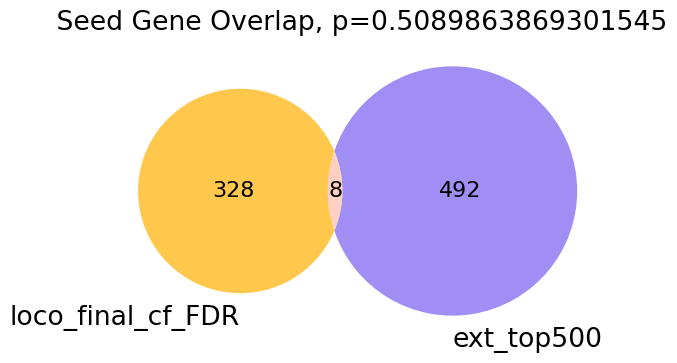

In [24]:
venn_seeds(seed_r, seed_h, label_r, label_h, colour_dict[trait_r],colour_dict[trait_h],all_nodes,interactome_name, savefig=save_fig)

# compare stats

## histogram and scatter plot NPS scores

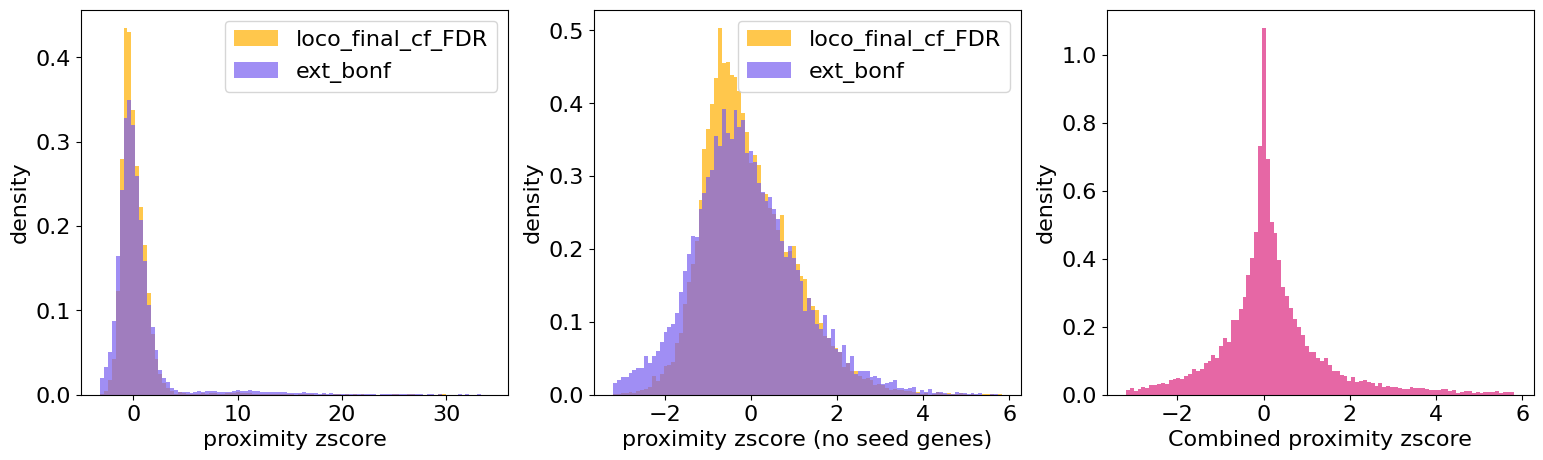

In [211]:
#import rare seed gene list and NPS scores
plt_histogram(tblr=NPS_r, tblc=NPS_h, 
              tblr_label=label_r, tblc_label=label_h,
              tblr_seed=seed_dict[label_r], tblc_seed=seed_dict[label_h], 
              colour_r=colour_dict[trait_r],colour_c=colour_dict[trait_h],colour_shared=colour_dict[shared_colour],
              tblr_lim=cut_single,
              tblc_lim=cut_single,
              comb_lim=cut_comb,
              savefig=save_fig,
             filename='NPS_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name)


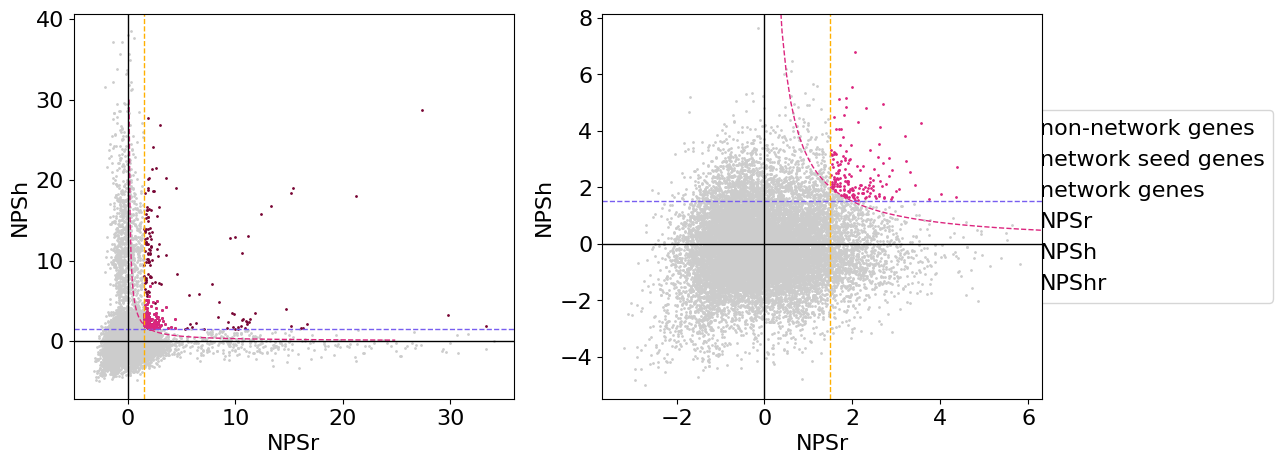

In [212]:
#import rare seed gene list and NPS scores
plt_scatter_NPS(tblr=NPS_r, tblc=NPS_h, 
              tblr_label='NPSr', tblc_label='NPSh',
              tblr_seed=seed_dict[label_r], tblc_seed=seed_dict[label_h], 
              colour_r=colour_dict[trait_r],colour_c=colour_dict[trait_h],colour_shared=colour_dict[shared_colour],colour_nonseed=colour_dict[shared_colour_alt],
              tblr_lim=cut_single,
              tblc_lim=cut_single,
              comb_lim=cut_comb,
              savefig=save_fig,
             filename='NPS_scatter'+'_'+label_r+'_'+label_h+'_'+interactome_name)


## network colocalization

In [15]:
zlist=[cut_comb]
z12list=[cut_single]

In [16]:
#set the Z-score cutoffs to calculate network enrichment significance
zlist = [1,2,3,4,5,6,7,8,9,10]
z12list = [1,1.5,2,3,4,5]


In [17]:
rerun_colocalization=False

In [18]:
coloc_filename=f'colocalization_scores/colocScore_{label_r}_{label_h}_{interactome_name}.tsv'
if rerun_colocalization | (not (os.path.exists(coloc_filename))):
    print('analyzing colocalization')
    netcoloc_enrichment_df = network_colocalization.calculate_network_enrichment(NPS_r,NPS_h,
                                                                             zthresh_list = zlist,
                                                                             z12thresh_list=z12list,
                                                                             verbose=False)
    #netcoloc_enrichment_df=netcoloc_enrichment_df[netcoloc_enrichment_df['z_comb']>=netcoloc_enrichment_df['NPS_single']]
    print(netcoloc_enrichment_df)
    netcoloc_enrichment_df['rat_dataset']=label_r
    netcoloc_enrichment_df['human_dataset']=label_h
    if save_fig:
        netcoloc_enrichment_df.to_csv(coloc_filename,sep='\t',index=False)
else:
    print(f'reading in {coloc_filename}')
    netcoloc_enrichment_df=pd.read_csv(coloc_filename,sep='\t')
pOverlap=float(netcoloc_enrichment_df[(netcoloc_enrichment_df['z_comb']==cut_comb) & (netcoloc_enrichment_df['z_12']==cut_single)]['empirical_p'])

reading in colocalization_scores/colocScore_loco_final_cf_FDR_ext_top500_PCNet2.0.tsv


### venn diagram of network colocalization (only colocalized network in center)

1.5
263


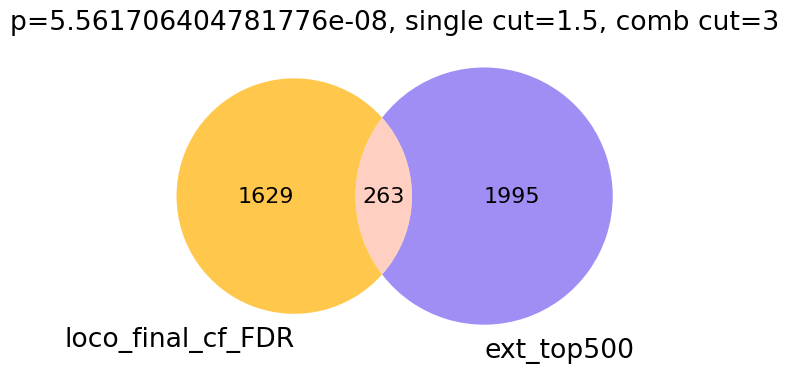

In [19]:
venn_net(tblr=NPS_r,tblc=NPS_h, tblr_label=label_r,tblc_label= label_h,p_net_overlap=pOverlap,
         colour_r=colour_dict[trait_r],colour_c=colour_dict[trait_h],colour_shared=colour_dict['shared'],
         tblr_lim=cut_single, tblc_lim=cut_single, comb_lim=3, savefig=save_fig)

### venn diagram of network colocalization (all nodes that pass npsr and npsh cutoffs in center)

            NPSr      NPSc     NPScr
0                                   
TGFBR1  2.235507 -1.153594 -2.578869
TGFBR2 -0.330384  0.966705 -0.319384
SMAD3   0.458796 -0.245730 -0.112740
TGFB1   0.534513  0.524767  0.280495
SMAD2   2.295971 -0.950918 -2.183280


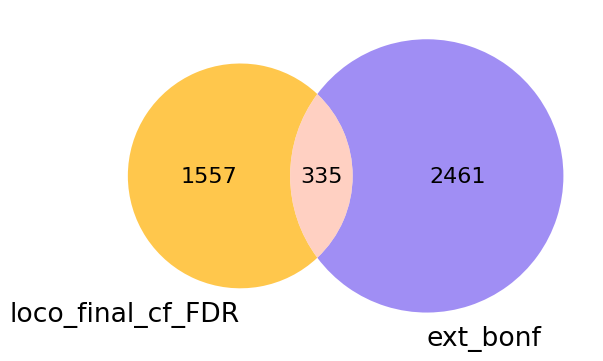

In [218]:
venn_net_NPSsingle(tblr=NPS_r,tblh=NPS_h, tblr_label=label_r,tblh_label= label_h,
         colour_r=colour_dict[trait_r],colour_h=colour_dict[trait_h],colour_shared=colour_dict['shared'],
         tblr_lim=cut_single, tblh_lim=cut_single, savefig=save_fig)

## histogram observed vs permuted network size

In [220]:
from IPython.display import SVG, display
def show_svg(file_path):
    with open(file_path, 'r') as f:
        svg_content = f.read()
    return SVG(svg_content)

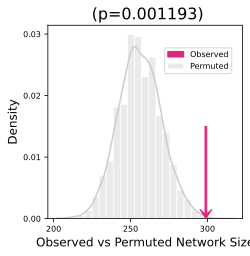

In [237]:
filename='networksize_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name
if os.path.exists(('figures/'+filename+'.svg')):
    display(show_svg('figures/'+filename+'.svg'))
else:
    print('calculating histogram')
    observed_sz, permuted_sz = network_colocalization.calculate_expected_overlap(NPS_r.iloc[:,0], NPS_h.iloc[:,0], 
                                                            z_score_threshold=cut_comb, z1_threshold=cut_single,
                                                            z2_threshold=cut_single, num_reps=10000, plot=False)  
    plot_permutation_histogram(permuted_sz, observed_sz, title="", xlabel="Observed vs Permuted Network Size", color=colour_dict['other'], arrow_color=colour_dict[shared_colour],savefig=save_fig, filename=filename)

calculating histogram


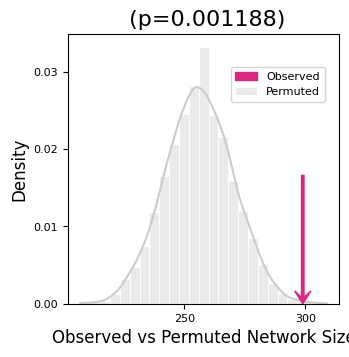

In [238]:
filename='networksize_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name+'_hm_permute'
if os.path.exists(('figures/'+filename+'.svg')):
    display(show_svg('figures/'+filename+'.svg'))
else:
    print('calculating histogram')
    observed_sz, permuted_sz = network_colocalization.calculate_expected_overlap(NPS_h.iloc[:,0], NPS_r.iloc[:,0], 
                                                            z_score_threshold=cut_comb, z1_threshold=cut_single,
                                                            z2_threshold=cut_single, num_reps=10000, plot=False)  
    plot_permutation_histogram(permuted_sz, observed_sz, title="", xlabel="Observed vs Permuted Network Size", color=colour_dict['other'], arrow_color=colour_dict[shared_colour],savefig=save_fig, filename=filename)

## histogram observed vs permuted mean NPS

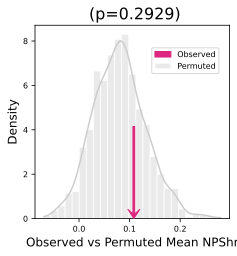

In [242]:
filename='mean_NPScr_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name
if os.path.exists(('figures/'+filename+'.svg')):
    display(show_svg('figures/'+filename+'.svg'))
else:
    print('calculating histogram')
    # Generate a null distribution of mean NPS by shuffling the z_scores. Note, due to randomization this distribution will not be exactly the same as the reported result
    observed_net, permuted_net = calculate_mean_z_score_distribution(pd.Series(NPS_r.iloc[:,0].dropna()), pd.Series(NPS_h.iloc[:,0].dropna()), num_reps=1000,
                                                            zero_double_negatives=False, overlap_control="bin",
                                                            seed1=list(set(seed_r).intersection(all_nodes)), seed2=list(set(seed_h).intersection(all_nodes)))
    plot_permutation_histogram(permuted_net, observed_net, title="", xlabel="Observed vs Permuted Mean NPShr", 
                               color=colour_dict['other'], arrow_color=colour_dict['shared'],
                               savefig=save_fig, 
                               filename=filename)

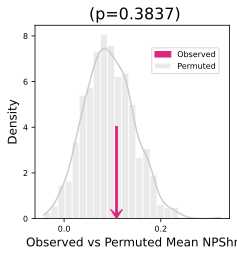

In [241]:
filename='mean_NPScr_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name+'hm_permute'
if os.path.exists(('figures/'+filename+'.svg')):
    display(show_svg('figures/'+filename+'.svg'))
else:
    print('calculating histogram')
    # Generate a null distribution of mean NPS by shuffling the z_scores. Note, due to randomization this distribution will not be exactly the same as the reported result
    observed_net, permuted_net = calculate_mean_z_score_distribution(pd.Series(NPS_h.iloc[:,0].dropna()), pd.Series(NPS_r.iloc[:,0].dropna()), num_reps=1000,
                                                            zero_double_negatives=False, overlap_control="bin",
                                                            seed1=list(set(seed_r).intersection(all_nodes)), seed2=list(set(seed_h).intersection(all_nodes)))
    plot_permutation_histogram(permuted_net, observed_net, title="", xlabel="Observed vs Permuted Mean NPShr", 
                               color=colour_dict['other'], arrow_color=colour_dict['shared'],
                               savefig=save_fig, 
                               filename=filename)

# sensitivity analysis -NPS scores

In [169]:
#toggle on whether to only include values where NPScomb>=NPSsingle^2
filter_coloc_fig=False

In [138]:
if ('netcoloc_enrichment_df' not in vars()):
    netcoloc_enrichment_df=pd.read_csv('colocalization_scores/colocScore_'+label_r+'_'+label_h+'_'+interactome_name+'.tsv',sep='\t')

In [141]:
netcoloc_enrichment_df['logp']=-np.log10(netcoloc_enrichment_df['empirical_p'])
netcoloc_enrichment_df.columns=['NPS_common-rare', 'NPS_single', 'observed_overlap', 'expected_overlap_mean',
       'expected_overlap_std', 'empirical_p', 'obs_exp', 'rare_dataset',
       'common_dataset', 'logp']

In [177]:
if filter_coloc_fig:
    enr_df=netcoloc_enrichment_df[(netcoloc_enrichment_df.NPS_single*netcoloc_enrichment_df.NPS_single)<=netcoloc_enrichment_df['NPS_common-rare']]
    enr_df=enr_df.reset_index()
else:
    enr_df=netcoloc_enrichment_df
temp=enr_df[enr_df['empirical_p']<0.05/len(enr_df)]

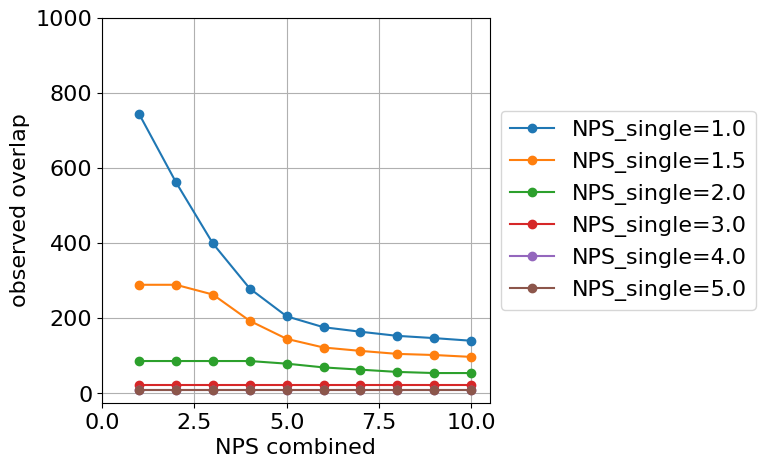

In [178]:
if filter_coloc_fig:
    title=f'sensitivity_analysis_network_overlap_filtered_{label_r}_{label_h}_{interactome_name}.svg'
else:
    title=f'sensitivity_analysis_network_overlap_{label_r}_{label_h}_{interactome_name}.svg'
NPS_lineplot(enr_df,'observed_overlap',title,xrange=[0,10.5],yrange=[-25,1000],savefig=save_fig)

/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(p)']=-np.log10(df['empirical_p'])


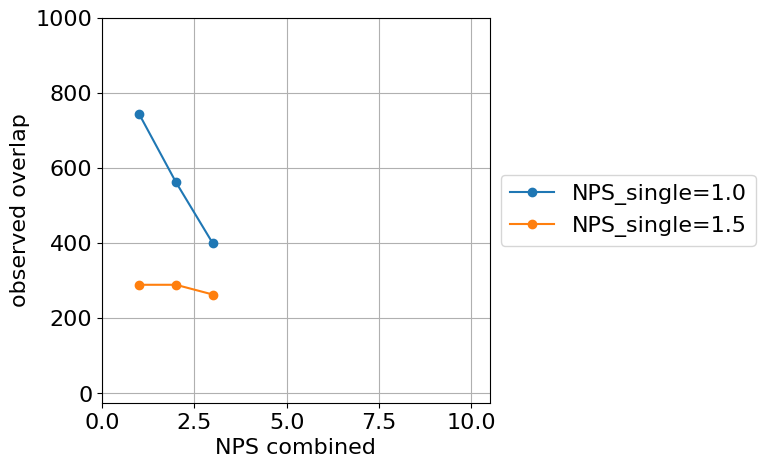

In [179]:
if filter_coloc_fig:
    title=f'sensitivity_analysis_network_overlap_sig_filtered_{label_r}_{label_h}_{interactome_name}.svg'
else:
    title=f'sensitivity_analysis_network_overlap_sig_{label_r}_{label_h}_{interactome_name}.svg'
NPS_lineplot(temp,'observed_overlap',title,xrange=[0,10.5],yrange=[-25,1000],savefig=save_fig)

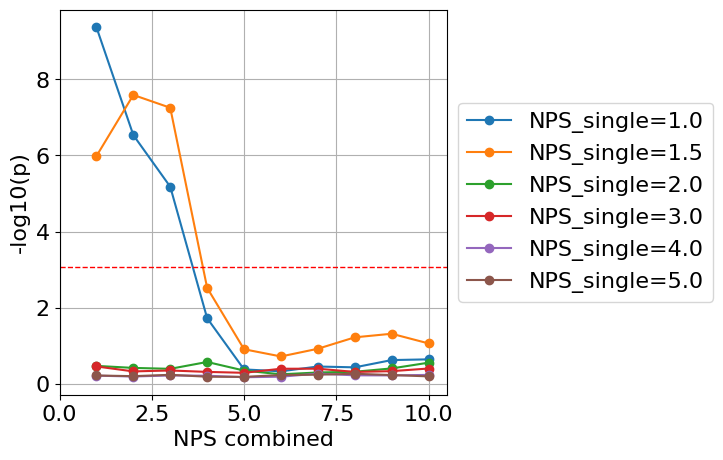

In [180]:
if filter_coloc_fig:
    title=f'sensitivity_analysis_overlap_pval_filtered_{label_r}_{label_h}_{interactome_name}.svg'
else:
    title=f'sensitivity_analysis_overlap_pval_{label_r}_{label_h}_{interactome_name}.svg'
NPS_lineplot(enr_df,'-log10(p)',title,xrange=[0,10.5],yrange=None, savefig=save_fig,sigline=True)

/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(p)']=-np.log10(df['empirical_p'])


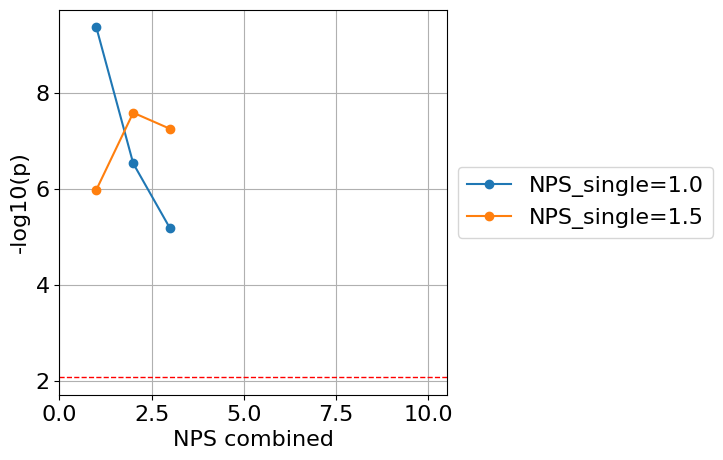

In [181]:
if filter_coloc_fig:
    title=f'sensitivity_analysis_overlap_pval_sig_filtered_{label_r}_{label_h}_{interactome_name}.svg'
else:
    title=f'sensitivity_analysis_overlap_pval_sig_{label_r}_{label_h}_{interactome_name}.svg'
NPS_lineplot(temp,'-log10(p)',title,xrange=[0,10.5],yrange=None, savefig=save_fig,sigline=True)

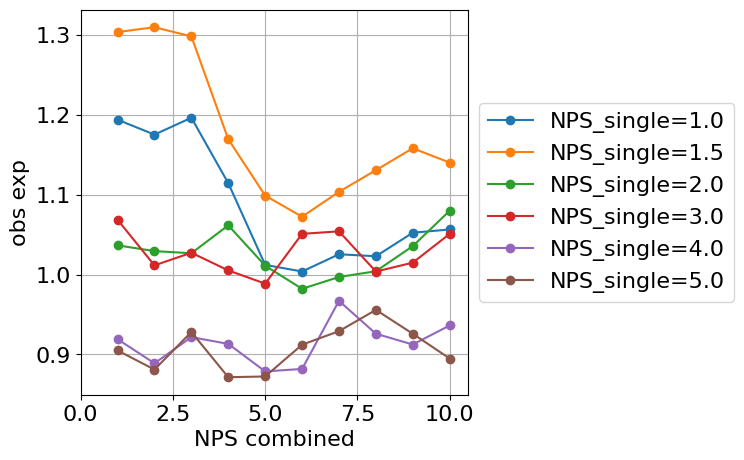

In [182]:
if filter_coloc_fig:
    title=f'sensitivity_analysis_obsexp_filtered_{label_r}_{label_h}_{interactome_name}.svg'
else:
    title=f'sensitivity_analysis_obsexp_{label_r}_{label_h}_{interactome_name}.svg'
NPS_lineplot(enr_df,'obs_exp',title,xrange=[0,10.5],yrange=None,savefig=save_fig)

/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(p)']=-np.log10(df['empirical_p'])


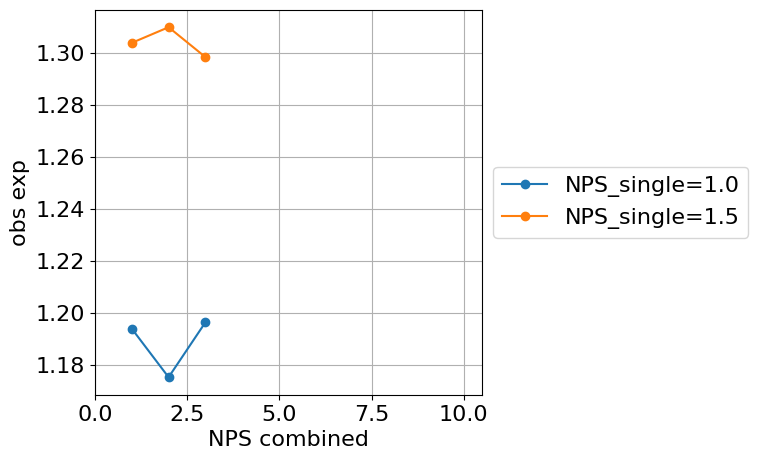

In [183]:
if filter_coloc_fig:
    title=f'sensitivity_analysis_obsexp_sig_filtered_{label_r}_{label_h}_{interactome_name}.svg'
else:
    title=f'sensitivity_analysis_obsexp_sig_{label_r}_{label_h}_{interactome_name}.svg'
NPS_lineplot(temp,'obs_exp',title,xrange=[0,10.5],yrange=None,savefig=save_fig)

# generate colocalized locomotor-ext network (unannotated)- save to ndexbio

In [27]:
net=network_colocalization.calculate_network_overlap_subgraph(
    interactome, pd.Series(NPS_r['z']), pd.Series(NPS_h['z']), cut_comb, cut_single, cut_single)
net2=format_network(net, label_r, label_h, seed_r , seed_h, NPS_r['z'], NPS_h['z'])
print(net2.nodes())
if save_fig:
    print('exporting network to NDEx')
    export_network(network=net, name=(label_r+'_'+label_h+'_'+interactome_name+'_MAGMA'), user=ndex_user, password=ndex_password)
    

['SMAD4', 'ACVR2A', 'RPS6KB1', 'HMMR', 'SH3PXD2A', 'PKN1', 'SRGAP2', 'ITGA3', 'FGFR1', 'AKT3', 'SNTG1', 'ARL13B', 'RNF5', 'MARCHF7', 'RAPSN', 'GPM6A', 'GNPDA2', 'CCT7', 'DPYSL2', 'PI4KA', 'SMARCA5', 'USP7', 'DPM2', 'GEMIN5', 'EDRF1', 'MAPT', 'PAICS', 'KCNT1', 'CHRNA2', 'SCN1A', 'KCNQ3', 'MTMR9', 'STXBP1', 'DHX38', 'ZMYND10', 'HIPK4', 'SEC16B', 'RB1CC1', 'CCDC40', 'CAMKV', 'PTER', 'KCNMA1', 'GABRG1', 'GABRA2', 'CHRNA3', 'AGTRAP', 'QPCTL', 'BCDIN3D', 'CRHR1', 'GABRA4', 'GABRA6', 'GRIN2B', 'GAD1', 'GABRD', 'DAOA', 'GRIK3', 'CALB2', 'KCNJ6', 'RARRES1', 'TBR1', 'FEZF2', 'GRIA1', 'FOXP2', 'BCL11B', 'GRIK1', 'GABRB3', 'CUX2', 'NEUROD1', 'CUX1', 'STMN2', 'GRIN3A', 'GSX2', 'PTPRN', 'CHRNA7', 'LAMP5', 'NRXN3', 'CHRNA6', 'NLGN1', 'GRM1', 'GRM7', 'FYN', 'CACNA1B', 'CACNG3', 'KCNJ4', 'ASIC1', 'MYT1', 'PCDH8', 'LRRTM1', 'DNM1', 'DPP6', 'GLRA1', 'ZDHHC17', 'KCNA2', 'RBFOX1', 'GABRR1', 'KCND2', 'CPNE6', 'DLG2', 'SLC8A2', 'CACNA1E', 'GRIP2', 'CDKL5', 'STMN4', 'PAX4', 'ASIC2', 'CACNA1D', 'CHRM4', 'KCNB2

# check GO enrichment for seed genes vs network genes

In [21]:
print_enr=False

## rat seed

In [25]:
enr_r = pd.DataFrame(gp.profile(organism='hsapiens',query=list(seed_r),sources=['GO:BP'],significance_threshold_method='fdr'))
enr_r=enr_r[(enr_r['term_size']<5000)&(enr_r['term_size']>5)]
enr_r=enr_r.sort_values('p_value')
if print_enr:
    print(f'enrichment for {label_r} (n={len(seed_r)})')
    if (len(enr_r)>0):
        print(set(enr_r.name))
    else:
        print('NA')

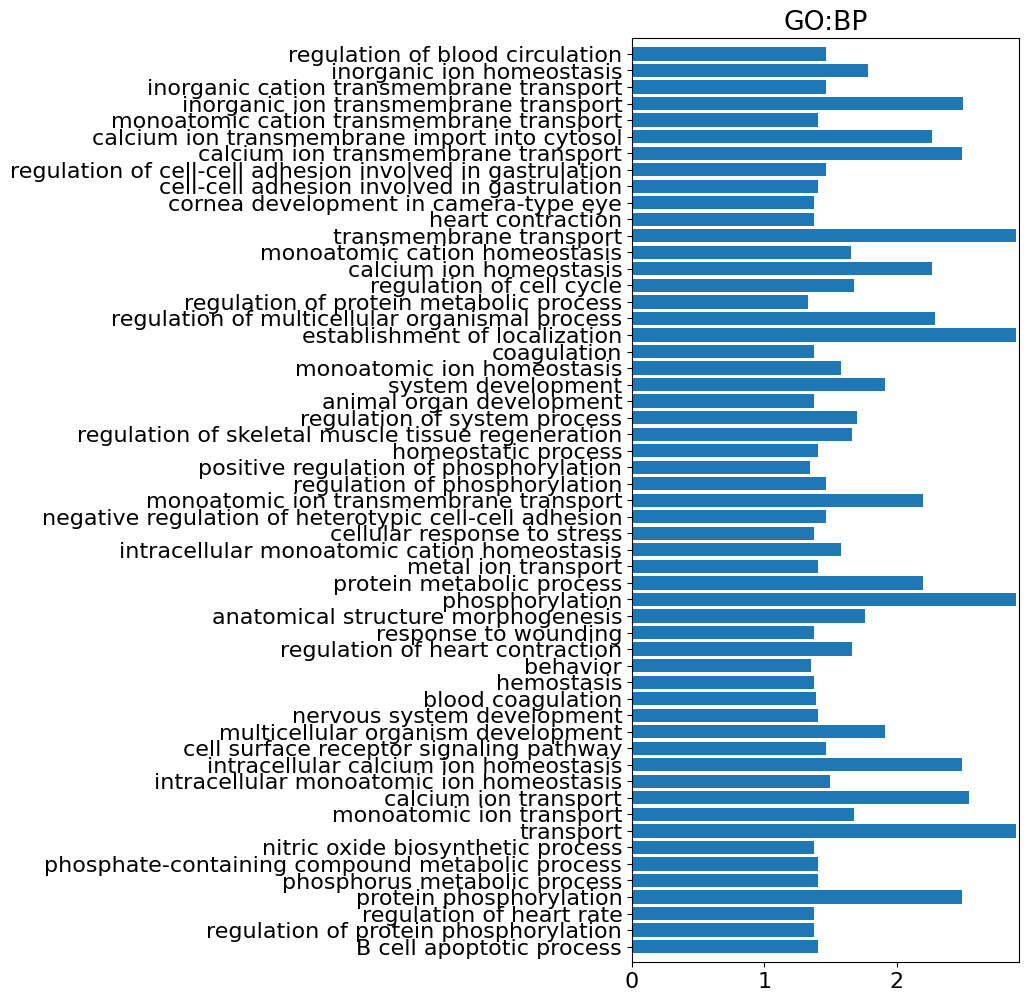

In [30]:
for s in set(enr_r.source):
    r=enr_r[enr_r.source==s].sort_values('native')
    plt.figure(figsize=(5, 12))
    plt.barh(r.name,-np.log10(r.p_value))
    plt.title(label=s)
    plt.margins(0.01)

## seed human

In [32]:
enr_h = pd.DataFrame(gp.profile(organism='hsapiens',query=list(seed_h),sources=['GO:BP'],significance_threshold_method='fdr'))
enr_h=enr_h[(enr_h['term_size']<5000)&(enr_h['term_size']>5)]
enr_h=enr_h.sort_values('p_value', ascending=False)
if print_enr:
    print(f'enrichment for {label_h} (n={len(seed_h)})')
    if (len(enr_h)>0):
        print(set(enr_h.name))
    else:
        print('NA')

In [65]:
enr_h=enr_h.sort_values('native')

In [70]:
set(enr_r.name)

{'B cell apoptotic process',
 'anatomical structure morphogenesis',
 'animal organ development',
 'behavior',
 'blood coagulation',
 'calcium ion homeostasis',
 'calcium ion transmembrane import into cytosol',
 'calcium ion transmembrane transport',
 'calcium ion transport',
 'cell surface receptor signaling pathway',
 'cell-cell adhesion involved in gastrulation',
 'cellular response to stress',
 'coagulation',
 'cornea development in camera-type eye',
 'establishment of localization',
 'heart contraction',
 'hemostasis',
 'homeostatic process',
 'inorganic cation transmembrane transport',
 'inorganic ion homeostasis',
 'inorganic ion transmembrane transport',
 'intracellular calcium ion homeostasis',
 'intracellular monoatomic cation homeostasis',
 'intracellular monoatomic ion homeostasis',
 'metal ion transport',
 'monoatomic cation homeostasis',
 'monoatomic cation transmembrane transport',
 'monoatomic ion homeostasis',
 'monoatomic ion transmembrane transport',
 'monoatomic ion 

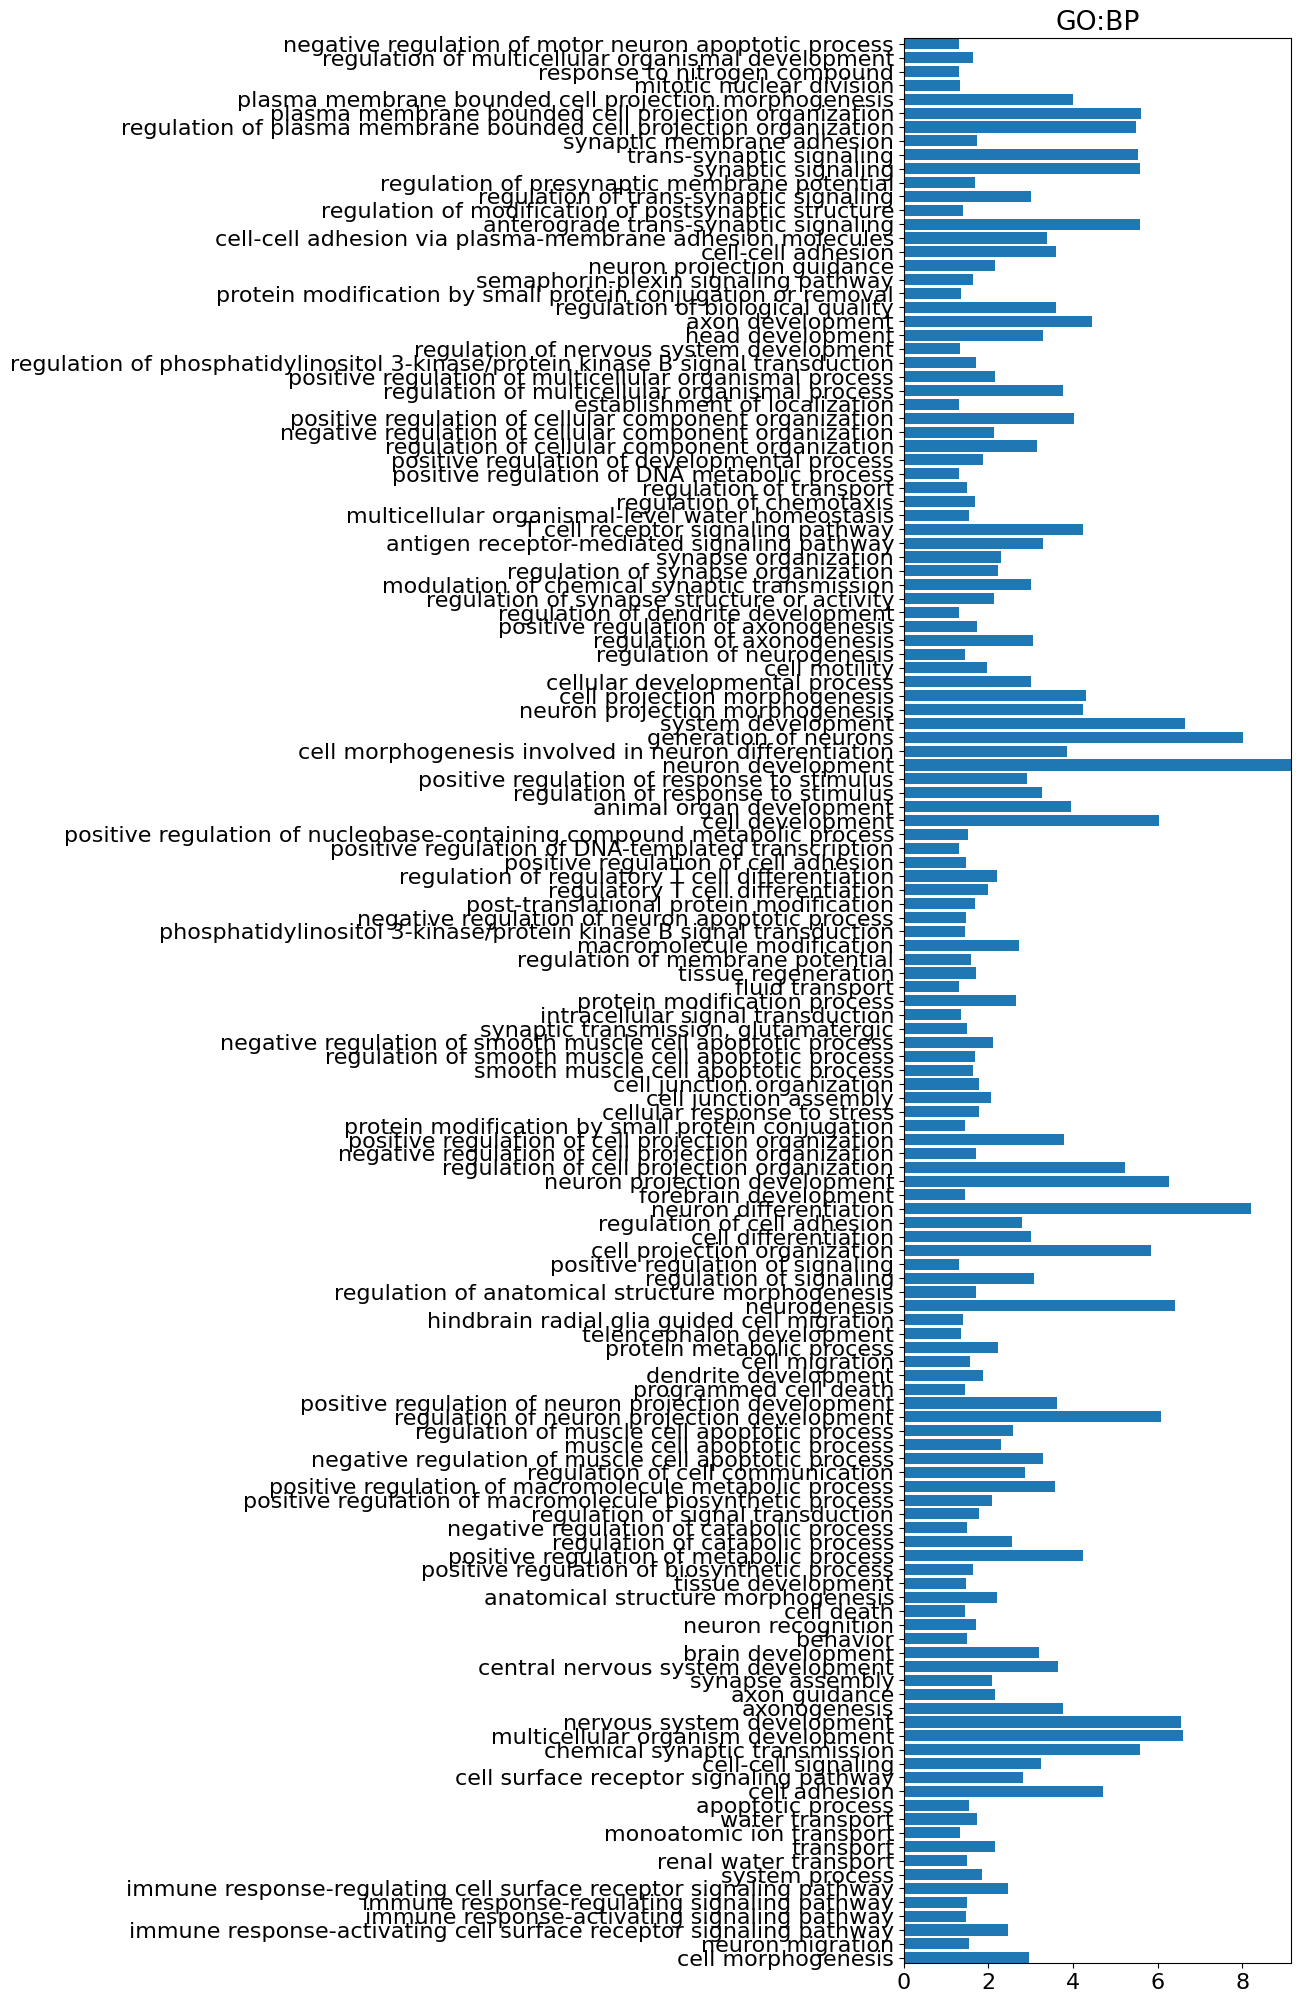

In [48]:
for s in set(enr_h.source):
    r=enr_h[enr_h.source==s]
    plt.figure(figsize=(5, 25))
    plt.barh(r.name,-np.log10(r.p_value))
    plt.title(label=s)
    plt.margins(0)

## network genes

In [38]:
netgenes=list(NPS[(NPS.zh>cut_single)&(NPS.zr>cut_single)&(NPS.zhr>cut_comb)].index)

In [39]:
enr_net = pd.DataFrame(gp.profile(organism='hsapiens',sources=['GO:BP'],query=list(netgenes),significance_threshold_method='fdr'))
enr_net=enr_net[(enr_net['term_size']<5000)&(enr_net['term_size']>5)]
enr_net=enr_net.sort_values('p_value')
if print_enr:
    print(f'enrichment for {label_h} x {label_r} (n={len(netgenes)})')
    if (len(results)>0):
        print(set(results.name))
    else:
        print('NA')

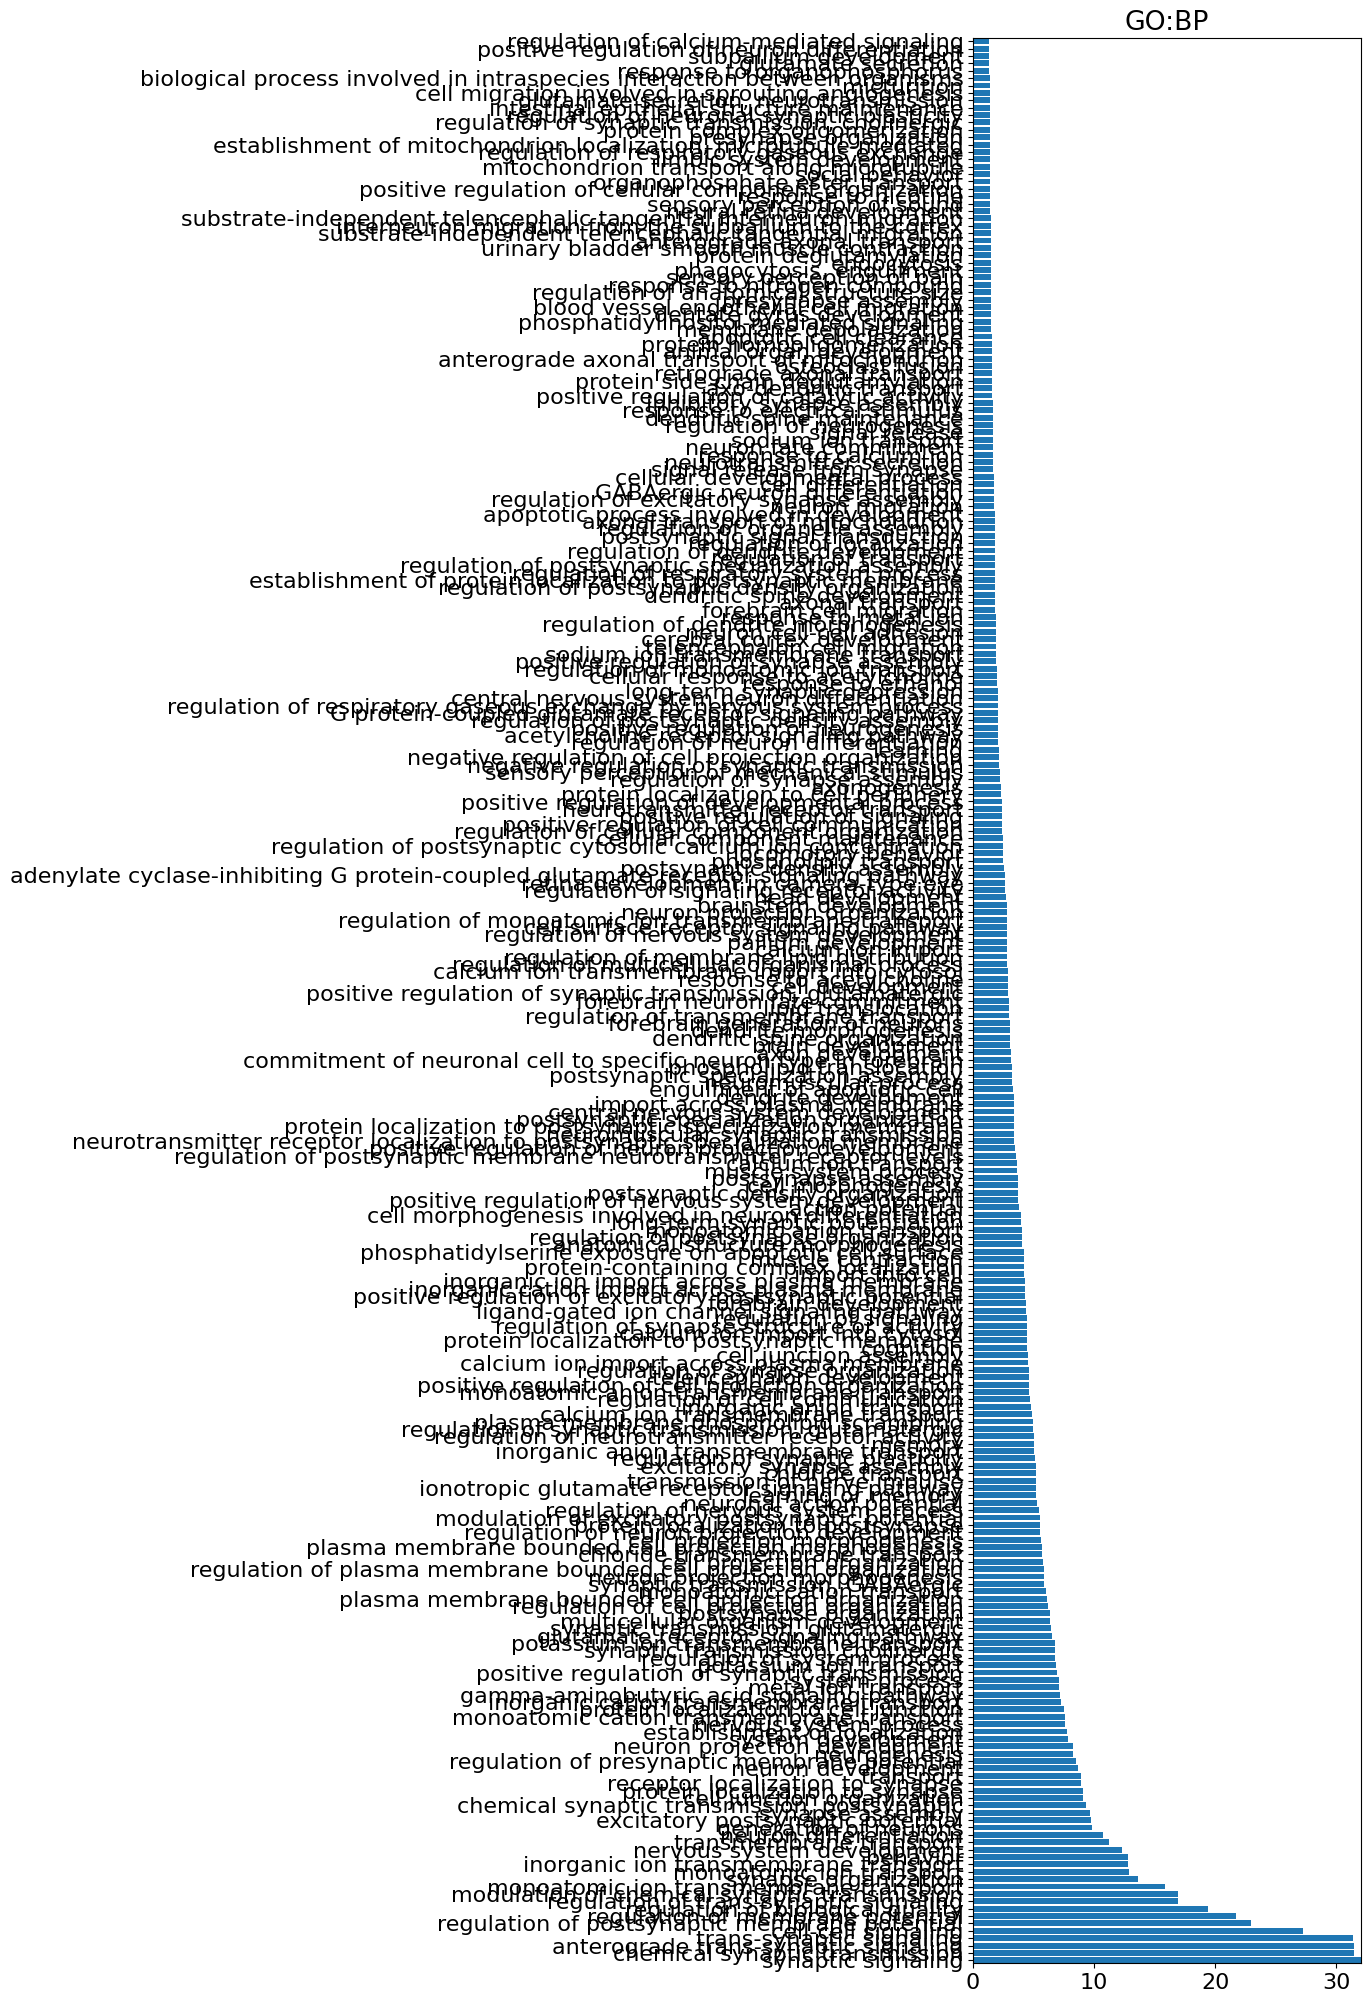

In [42]:
for s in set(enr_net.source):
    r=enr_net[enr_net.source==s]
    plt.figure(figsize=(5, 25))
    plt.barh(r.name,-np.log10(r.p_value))
    plt.title(label=s)
    plt.margins(0)

In [72]:
set(enr_net.name)

{'G protein-coupled glutamate receptor signaling pathway',
 'GABAergic neuron differentiation',
 'acetylcholine receptor signaling pathway',
 'action potential',
 'adenylate cyclase-inhibiting G protein-coupled glutamate receptor signaling pathway',
 'anatomical structure morphogenesis',
 'animal organ development',
 'anterograde axonal transport',
 'anterograde axonal transport of mitochondrion',
 'anterograde trans-synaptic signaling',
 'apoptotic cell clearance',
 'apoptotic process involved in development',
 'axo-dendritic transport',
 'axon development',
 'axonal transport',
 'axonal transport of mitochondrion',
 'axonogenesis',
 'behavior',
 'biological process involved in intraspecies interaction between organisms',
 'blood vessel endothelial cell migration',
 'brain development',
 'brainstem development',
 'calcium ion import',
 'calcium ion import across plasma membrane',
 'calcium ion import into cytosol',
 'calcium ion transmembrane import into cytosol',
 'calcium ion transm

## compare across the 3

### venn diagram

In [191]:
sns.color_palette('pastel6')
#sns.color_palette('pastel6').as_hex()[0]

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

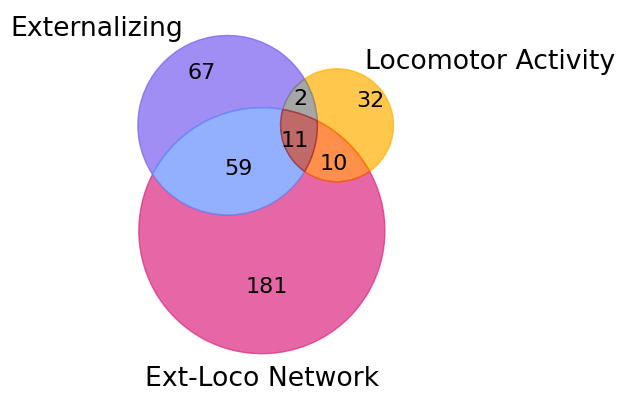

In [75]:
# Define the three sets of genes
set1 = set(enr_h.name)
set2 =set(enr_r.name)
set3 =set(enr_net.name)

# Create the Venn diagram
venn = venn3([set1, set2, set3], ('Externalizing', 'Locomotor Activity', 'Ext-Loco Network'),alpha=0.7)

colors = {
    '100': colour_dict['ext'], '010': colour_dict['loco'], '001': colour_dict['shared'],
    '110': 'grey', '101': colour_dict['ext_alt'], '011':colour_dict['loco_alt'], '111': 'brown'
}
for id_, color in colors.items():
    patch = venn.get_patch_by_id(id_)
    if patch:
        patch.set_color(color)
if save_fig:
    plt.savefig(f'figures/GOBP_enr_venn_seed_vs_network_{label_r}_{label_h}.svg')
plt.show()


In [58]:
r=set(enr_r.name)

In [57]:
h=set(enr_h.name)

In [56]:
n=set(enr_net.name)

In [74]:
(r.intersection(h)).intersection(n)

{'anatomical structure morphogenesis',
 'animal organ development',
 'behavior',
 'cell surface receptor signaling pathway',
 'establishment of localization',
 'monoatomic ion transport',
 'multicellular organism development',
 'nervous system development',
 'regulation of multicellular organismal process',
 'system development',
 'transport'}

In [60]:
r.intersection(h).difference(n)

{'cellular response to stress', 'protein metabolic process'}

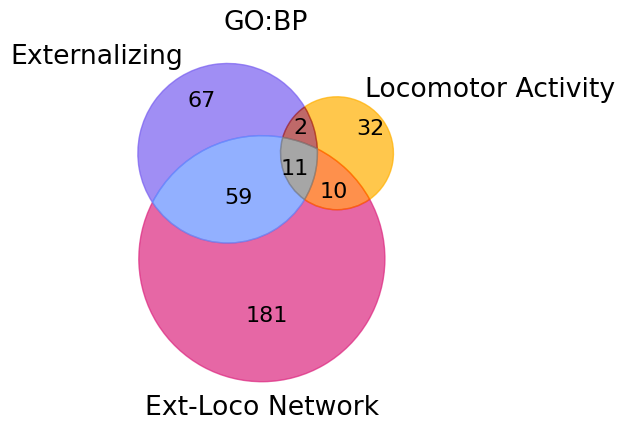

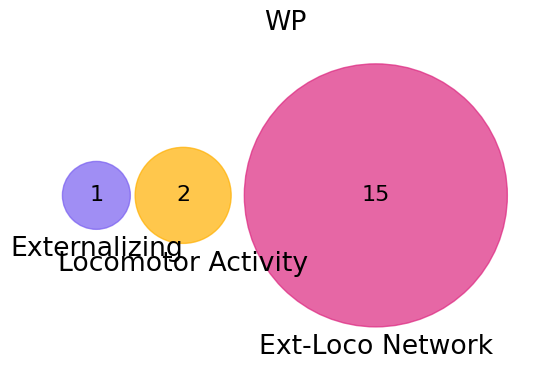

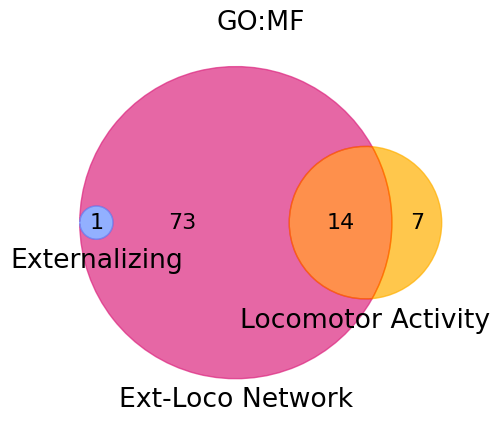

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:57: UserWarning: Circle B has zero area
  warnings.warn("Circle B has zero area")


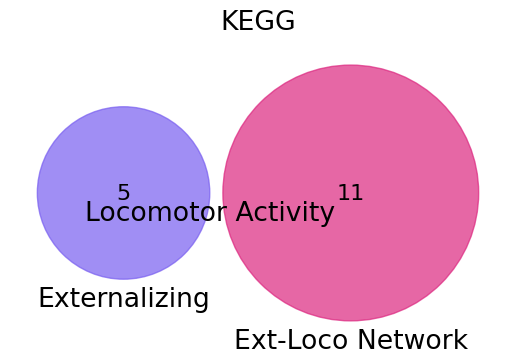

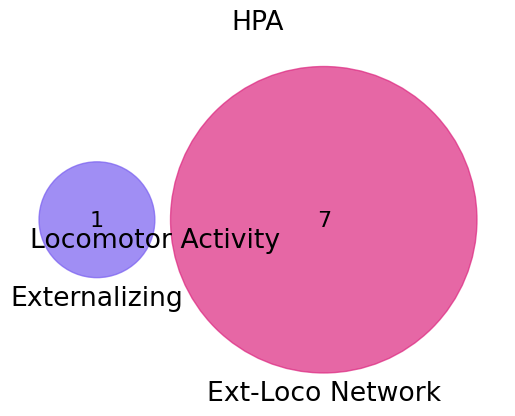

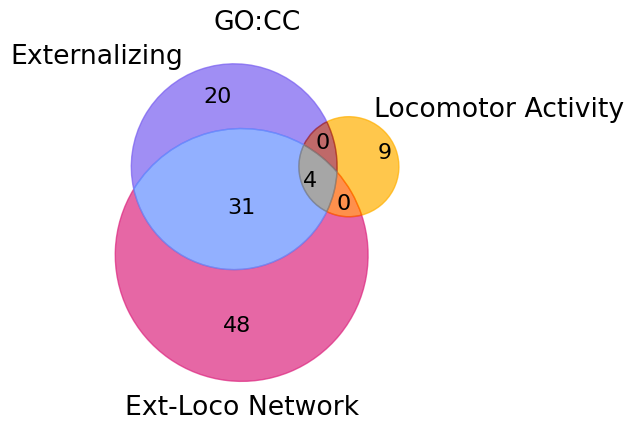

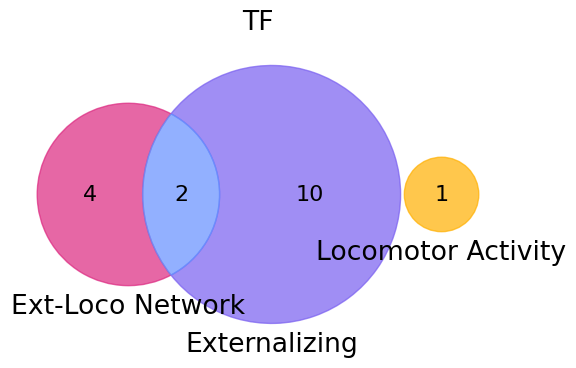

In [200]:
# Define the three sets of genes
for s in set(enr_h.source):
    set1 = set(enr_h[enr_h.source==s].name)
    set2 = set(enr_r[enr_r.source==s].name)
    set3 = set(enr_net[enr_net.source==s].name)
    
    # Create the Venn diagram
    venn = venn3([set1, set2, set3], ('Externalizing', 'Locomotor Activity', 'Ext-Loco Network'),alpha=0.7)
    
    colors = {
        '100': colour_dict['ext'], '010': colour_dict['loco'], '001': colour_dict['shared'],
        '110': 'brown', '101': colour_dict['ext_alt'], '011':colour_dict['loco_alt'], '111': 'grey'
    }
    for id_, color in colors.items():
        patch = venn.get_patch_by_id(id_)
        if patch:
            patch.set_color(color)
    
    plt.title(s)
    plt.show()


### scatter- all overlap

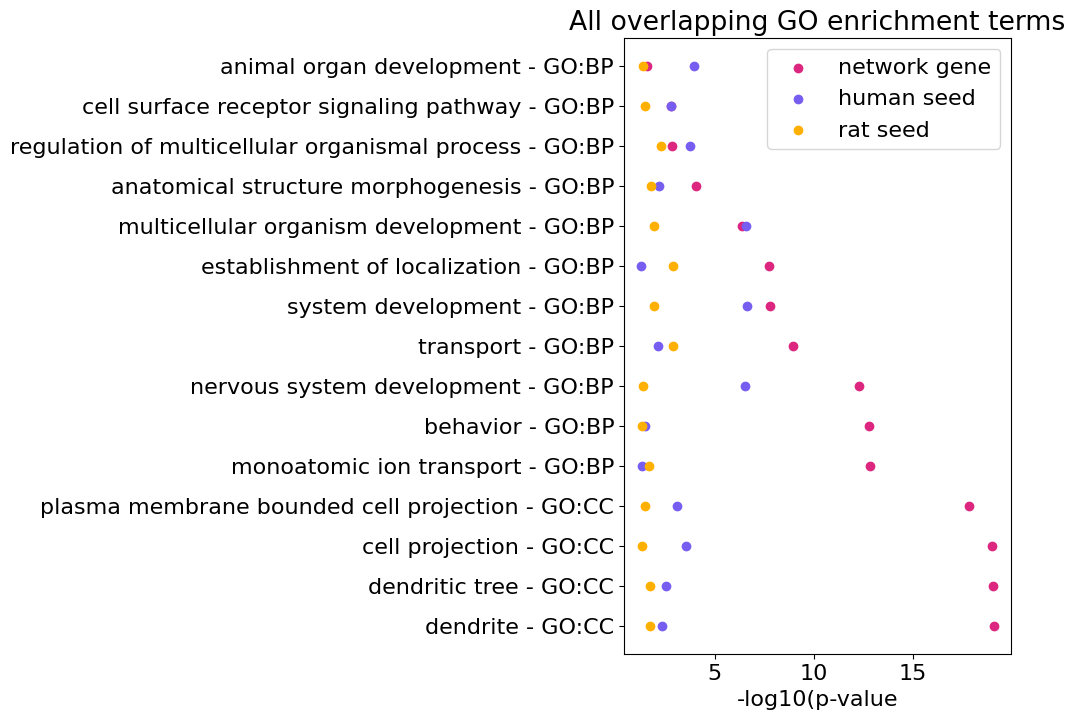

In [201]:
x=set(enr_net['name']).intersection(enr_r['name']).intersection(enr_h['name'])

n=enr_net[(enr_net.name.isin(x))]
r=enr_r[(enr_r.name.isin(x))]
h=enr_h[(enr_h.name.isin(x))]

plt.figure(figsize=(5,8))
plt.scatter(y=n['name']+' - '+ n['source'],x=-np.log10(n['p_value']),color=colour_dict['shared'],label='network gene')
plt.scatter(y=h['name']+' - '+ h['source'],x=-np.log10(h['p_value']),color=colour_dict['ext'],label='human seed')
plt.scatter(y=r['name']+' - '+ r['source'],x=-np.log10(r['p_value']),color=colour_dict['loco'],label='rat seed')
plt.xlabel('-log10(p-value')
plt.title('All overlapping GO enrichment terms')
plt.margins(0.05)
plt.legend()


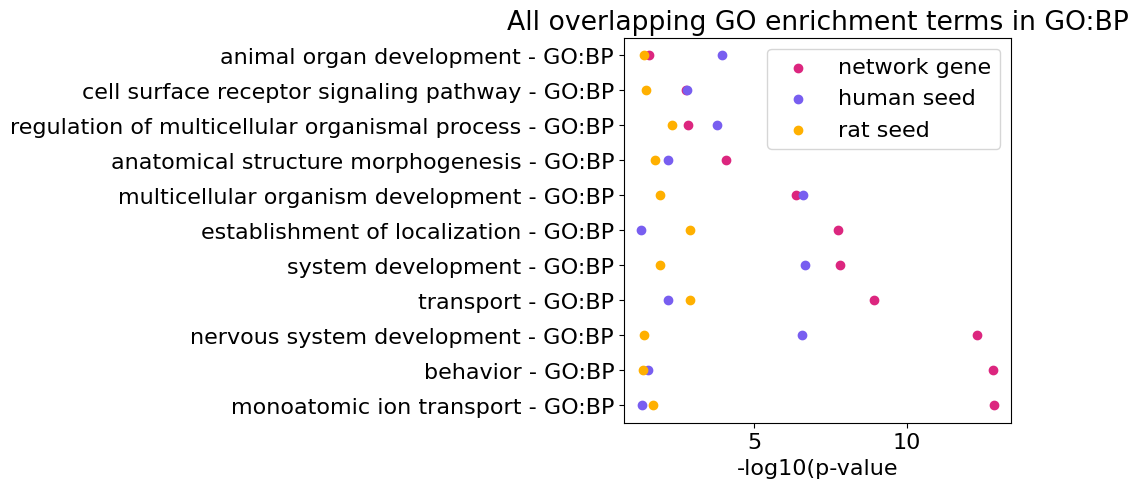

In [202]:
x=set(enr_net['name']).intersection(enr_r['name']).intersection(enr_h['name'])

s='GO:BP'
n=enr_net[(enr_net.name.isin(x))&(enr_net.source==s)]
r=enr_r[(enr_r.name.isin(x))&(enr_r.source==s)]
h=enr_h[(enr_h.name.isin(x))&(enr_h.source==s)]



plt.figure(figsize=(5,5))
plt.scatter(y=n['name']+' - '+ n['source'],x=-np.log10(n['p_value']),color=colour_dict['shared'],label='network gene')
plt.scatter(y=h['name']+' - '+ h['source'],x=-np.log10(h['p_value']),color=colour_dict['ext'],label='human seed')
plt.scatter(y=r['name']+' - '+ r['source'],x=-np.log10(r['p_value']),color=colour_dict['loco'],label='rat seed')
plt.xlabel('-log10(p-value')
plt.title(f'All overlapping GO enrichment terms in {s}')
plt.margins(0.05)
plt.legend()


### human vs rat

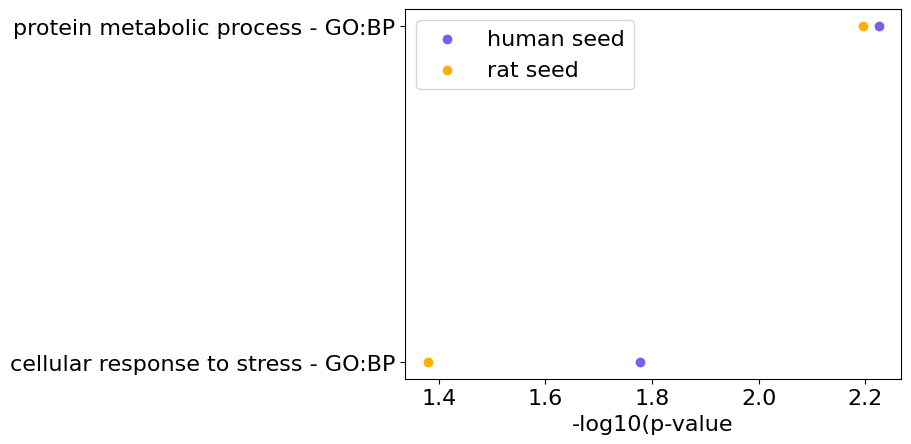

In [203]:
x=set(enr_h['name']).intersection(enr_r['name']).difference(enr_net['name'])
plt.scatter(y=enr_h[enr_h.name.isin(x)]['name']+' - '+ enr_h[enr_h.name.isin(x)]['source'],x=-np.log10(enr_h[enr_h.name.isin(x)]['p_value']),color=colour_dict['ext'],label='human seed')
plt.scatter(y=enr_r[enr_r.name.isin(x)]['name']+' - '+ enr_r[enr_r.name.isin(x)]['source'],x=-np.log10(enr_r[enr_r.name.isin(x)]['p_value']),color=colour_dict['loco'],label='rat seed')
plt.xlabel('-log10(p-value')
plt.legend()

### human vs network

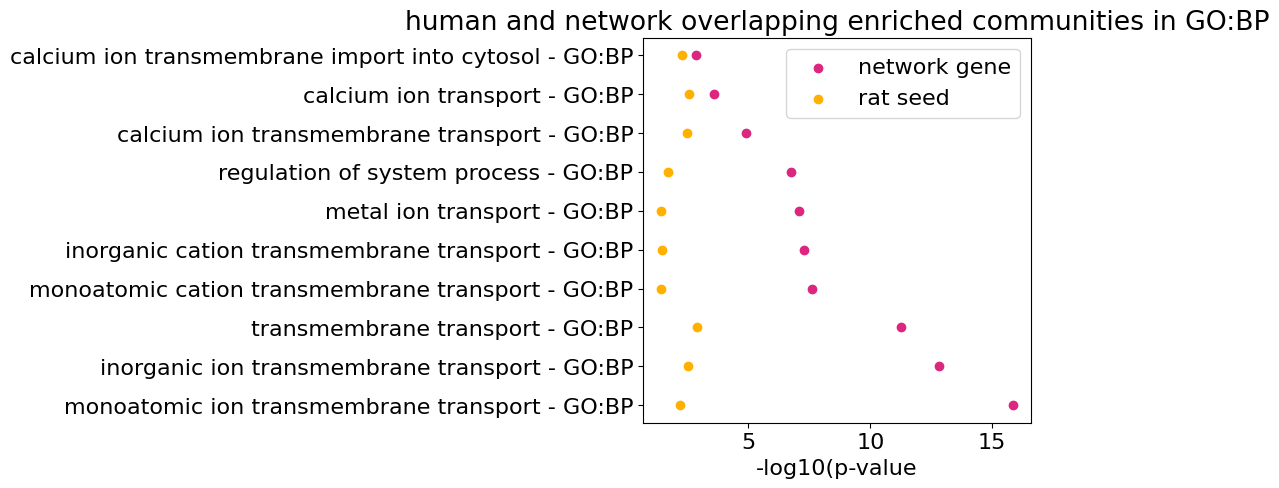

In [204]:
x=set(enr_net['name']).intersection(enr_r['name']).difference(enr_h['name'])
s='GO:BP'
n=enr_net[(enr_net.name.isin(x))&(enr_net.source==s)]
r=enr_r[(enr_r.name.isin(x))&(enr_r.source==s)]
h=enr_h[(enr_h.name.isin(x))&(enr_h.source==s)]


plt.figure(figsize=(5,5))
plt.scatter(y=n['name']+' - '+ n['source'],x=-np.log10(n['p_value']),color=colour_dict['shared'],label='network gene')
#plt.scatter(y=h['name']+' - '+ h['source'],x=-np.log10(h['p_value']),color=colour_dict['ext'],label='human seed')
plt.scatter(y=r['name']+' - '+ r['source'],x=-np.log10(r['p_value']),color=colour_dict['loco'],label='rat seed')
plt.xlabel('-log10(p-value')
plt.title(f'human and network overlapping enriched communities in {s}')
plt.margins(0.05)
plt.legend()


### human vs network

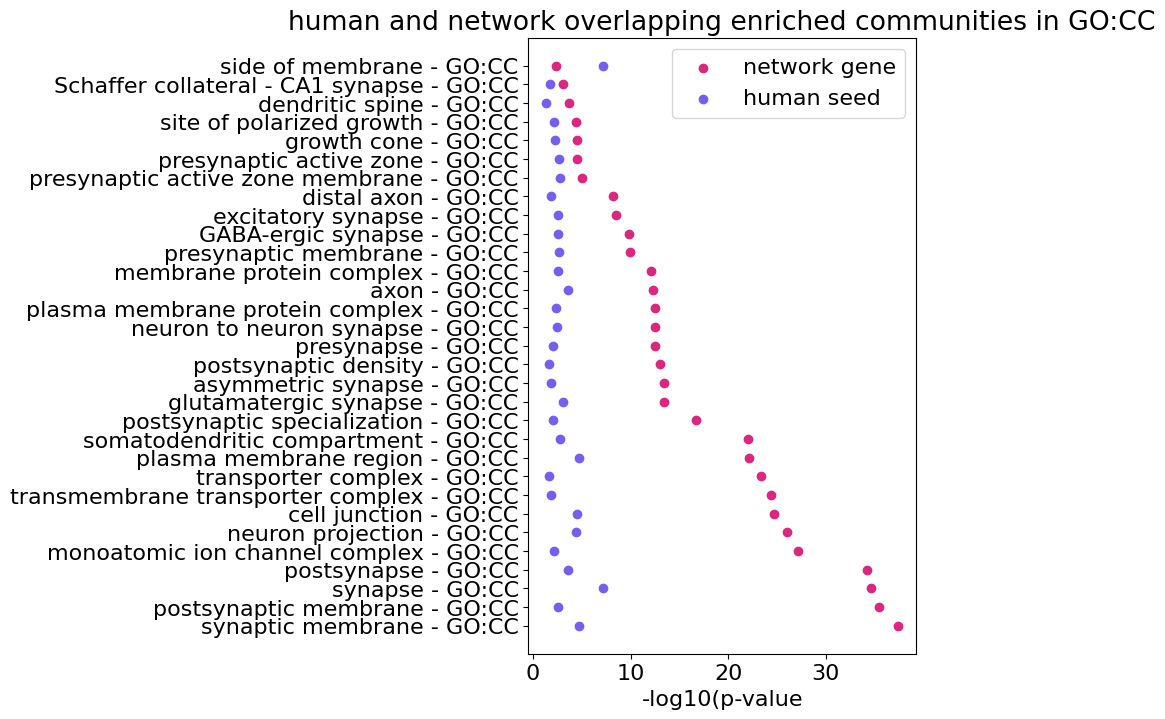

In [205]:
x=set(enr_net['name']).intersection(enr_h['name']).difference(enr_r['name'])
s='GO:CC'
n=enr_net[(enr_net.name.isin(x))&(enr_net.source==s)]
r=enr_r[(enr_r.name.isin(x))&(enr_r.source==s)]
h=enr_h[(enr_h.name.isin(x))&(enr_h.source==s)]


plt.figure(figsize=(5,8))
plt.scatter(y=n['name']+' - '+ n['source'],x=-np.log10(n['p_value']),color=colour_dict['shared'],label='network gene')
plt.scatter(y=h['name']+' - '+ h['source'],x=-np.log10(h['p_value']),color=colour_dict['ext'],label='human seed')
#plt.scatter(y=r['name']+' - '+ r['source'],x=-np.log10(r['p_value']),color=colour_dict['loco'],label='rat seed')
plt.xlabel('-log10(p-value')
plt.title(f'human and network overlapping enriched communities in {s}')
plt.margins(0.05)
plt.legend()


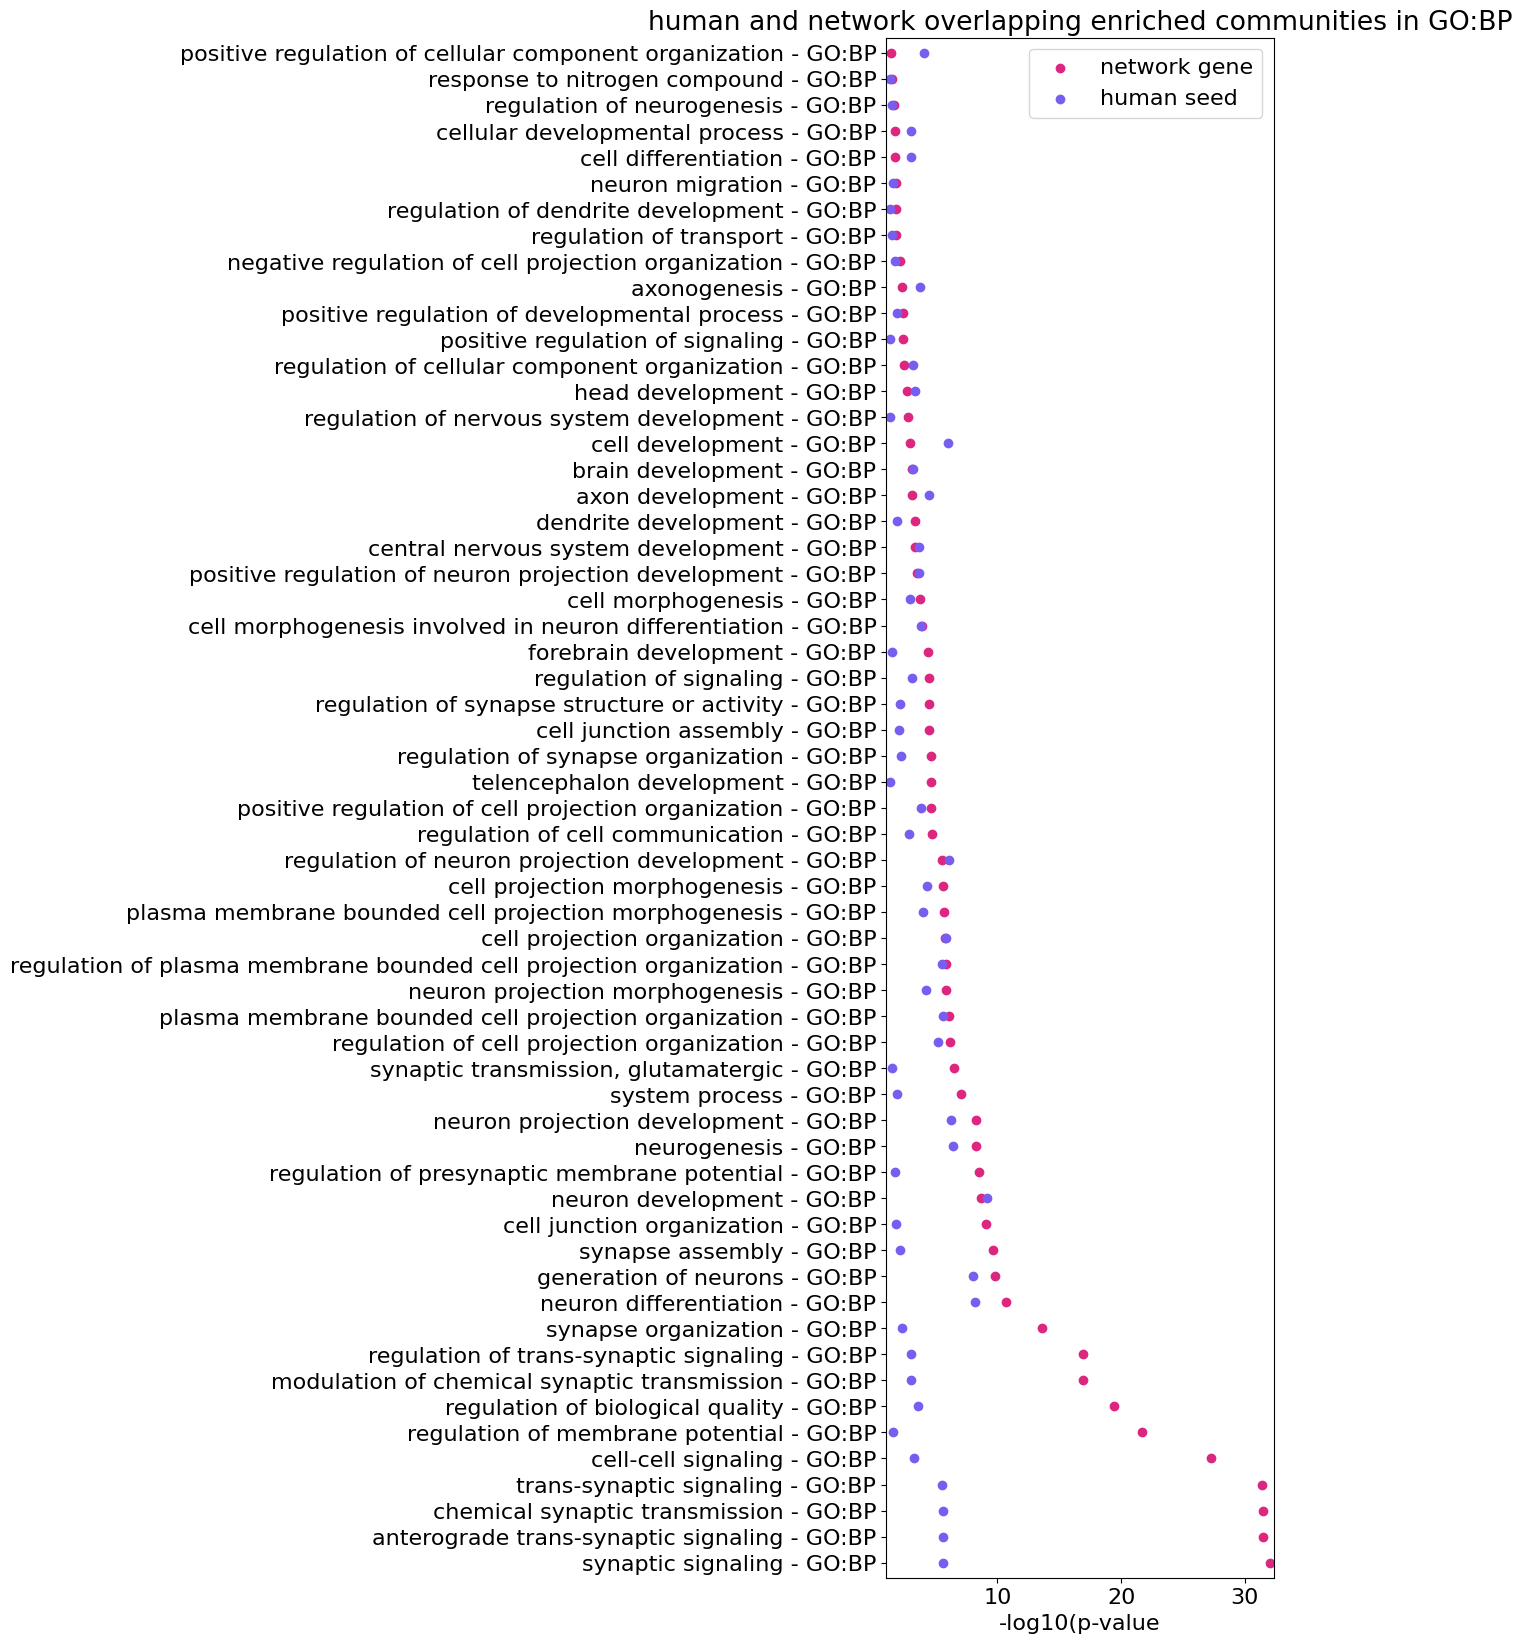

In [206]:
x=set(enr_net['name']).intersection(enr_h['name']).difference(enr_r['name'])
s='GO:BP'
n=enr_net[(enr_net.name.isin(x))&(enr_net.source==s)]
r=enr_r[(enr_r.name.isin(x))&(enr_r.source==s)]
h=enr_h[(enr_h.name.isin(x))&(enr_h.source==s)]


plt.figure(figsize=(5,20))
plt.scatter(y=n['name']+' - '+ n['source'],x=-np.log10(n['p_value']),color=colour_dict['shared'],label='network gene')
plt.scatter(y=h['name']+' - '+ h['source'],x=-np.log10(h['p_value']),color=colour_dict['ext'],label='human seed')
#plt.scatter(y=r['name']+' - '+ r['source'],x=-np.log10(r['p_value']),color=colour_dict['loco'],label='rat seed')
plt.xlabel('-log10(p-value')
plt.title(f'human and network overlapping enriched communities in {s}')
plt.margins(0.01)
plt.legend()


# map to ensembl IDs for FUMA

In [13]:
hgnc=pd.read_csv('hgnc_complete_set.txt',sep='\t',low_memory=False)

In [14]:
mapping=hgnc[['symbol','ensembl_gene_id']]

In [25]:
netgenes=list(NPS[(NPS.zh>cut_single)&(NPS.zr>cut_single)&(NPS.zhr>cut_comb)].index)

In [26]:
for n in list(mapping[mapping['symbol'].isin(seed_r)]['ensembl_gene_id']):
    print(n)

ENSG00000159640
ENSG00000100312
ENSG00000121989
ENSG00000104755
ENSG00000189007
ENSG00000118492
ENSG00000123146
ENSG00000112414
ENSG00000120907
ENSG00000116127
ENSG00000203795
ENSG00000213185
ENSG00000196550
ENSG00000147724
ENSG00000203780
ENSG00000196159
ENSG00000118496
ENSG00000177294
ENSG00000162897
ENSG00000162894
ENSG00000168522
ENSG00000183090
ENSG00000108592
ENSG00000001036
ENSG00000177283
ENSG00000151834
ENSG00000109158
ENSG00000163285
ENSG00000144278
ENSG00000168827
ENSG00000204188
ENSG00000259384
ENSG00000123159
ENSG00000177291
ENSG00000108010
ENSG00000185838
ENSG00000127920
ENSG00000127928
ENSG00000108433
ENSG00000185245
ENSG00000203618
ENSG00000154478
ENSG00000174948
ENSG00000152822
ENSG00000180613
ENSG00000177602
ENSG00000118418
ENSG00000188816
ENSG00000188620
ENSG00000171476
ENSG00000153936
ENSG00000002587
ENSG00000166033
ENSG00000108622
ENSG00000263528
ENSG00000136634
ENSG00000142224
ENSG00000162891
ENSG00000162892
ENSG00000071243
ENSG00000109452
ENSG00000146243
ENSG0000

In [29]:
for n in list(mapping[mapping['symbol'].isin(all_nodes)]['ensembl_gene_id']):
    print(n)

ENSG00000121410
ENSG00000148584
ENSG00000175899
ENSG00000166535
ENSG00000184389
ENSG00000128274
ENSG00000118017
ENSG00000094914
ENSG00000081760
ENSG00000114771
ENSG00000197953
ENSG00000188984
ENSG00000204518
ENSG00000109576
ENSG00000103591
ENSG00000115977
ENSG00000087884
ENSG00000127837
ENSG00000129673
ENSG00000131043
ENSG00000205002
ENSG00000090861
ENSG00000124608
ENSG00000266967
ENSG00000157426
ENSG00000149313
ENSG00000008311
ENSG00000275700
ENSG00000181409
ENSG00000183044
ENSG00000165029
ENSG00000107331
ENSG00000167972
ENSG00000198691
ENSG00000154265
ENSG00000154262
ENSG00000064687
ENSG00000141338
ENSG00000154258
ENSG00000154263
ENSG00000144452
ENSG00000179869
ENSG00000085563
ENSG00000005471
ENSG00000004846
ENSG00000115657
ENSG00000131269
ENSG00000197150
ENSG00000150967
ENSG00000135776
ENSG00000073734
ENSG00000103222
ENSG00000023839
ENSG00000108846
ENSG00000125257
ENSG00000114770
ENSG00000091262
ENSG00000006071
ENSG00000069431
ENSG00000124574
ENSG00000121270
ENSG00000140798
ENSG0000